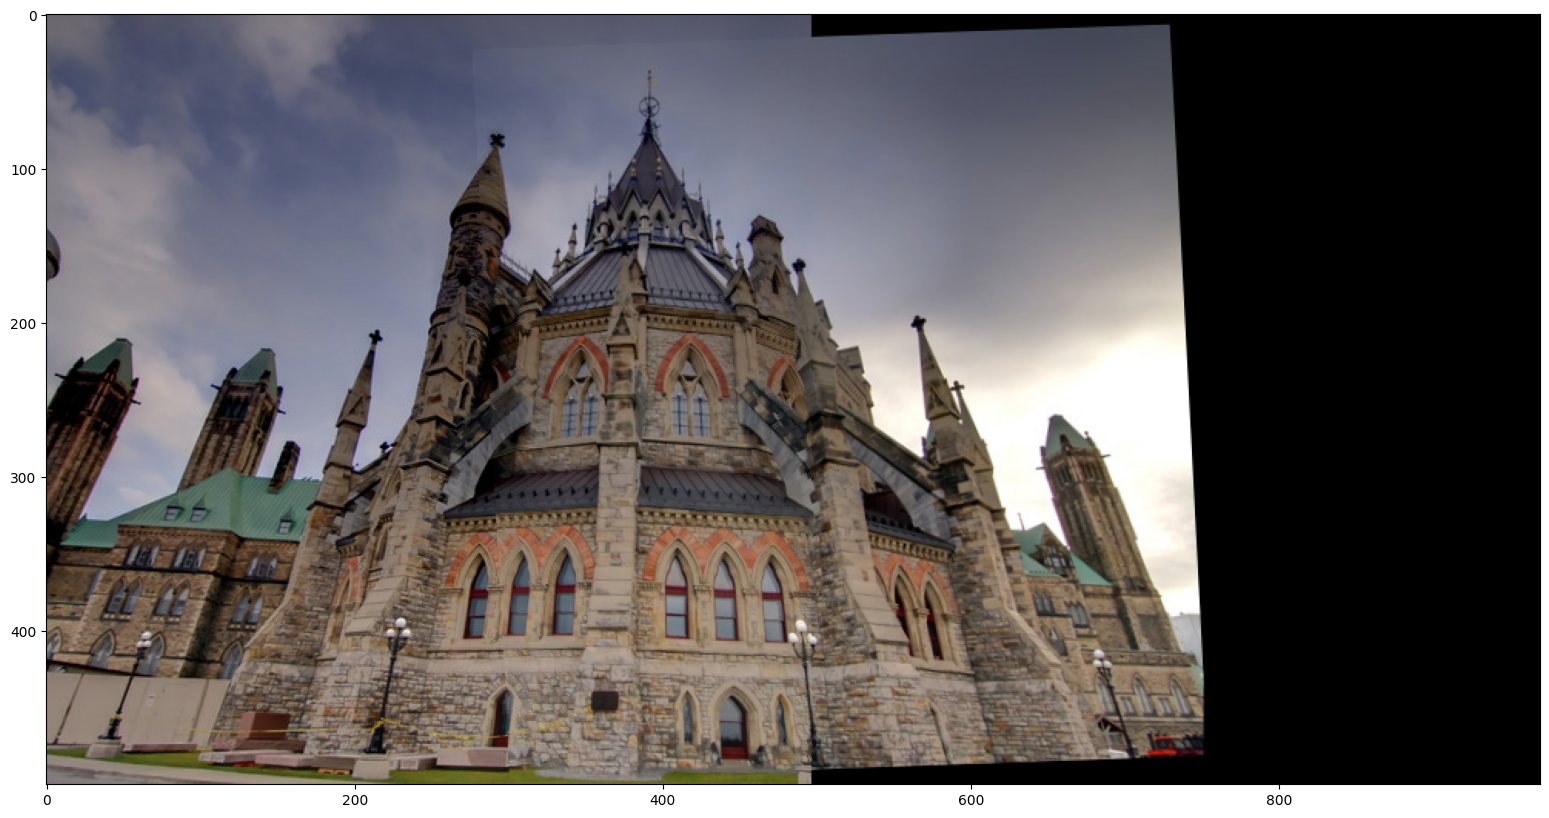

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from scipy.spatial import distance
import random
import skimage.transform as sk

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    Plot the matches between two images according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')


def main(leftImg, rightImg, threshold, p, iterations):
    
    #read image
    imgLeft = plt.imread(leftImg)
    imgRight = plt.imread(rightImg)
    
    #padding images to the same height
    if(imgLeft.shape[0] > imgRight.shape[0]):
        dis = imgLeft.shape[0] - imgRight.shape[0]
        imgRight = cv.copyMakeBorder(imgRight, dis, 0, 0, 0, cv.BORDER_CONSTANT)
        
    elif(imgLeft.shape[0] < imgRight.shape[0]):
        dis = imgRight.shape[0] - imgLeft.shape[0]
        imgLeft = cv.copyMakeBorder(imgLeft, dis, 0, 0, 0, cv.BORDER_CONSTANT)
        
    #grayscale
    grayLeft = cv.cvtColor(imgLeft,cv.COLOR_BGR2GRAY)
    grayRight = cv.cvtColor(imgRight,cv.COLOR_BGR2GRAY)

    #Detect keypoints and extract descriptors
    sift = cv.SIFT_create()

    keypointsLeft, descriptorLeft = sift.detectAndCompute(grayLeft, None)
    keypointsRight, descriptorRight = sift.detectAndCompute(grayRight, None)
    imgL = cv.drawKeypoints(grayLeft, keypointsLeft, descriptorLeft, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    imgR = cv.drawKeypoints(grayRight, keypointsRight, descriptorRight, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    #Match features
    dist = distance.cdist(descriptorLeft, descriptorRight, 'euclidean')
    
    #Prune features
    inliers = []
    tempList = []
    
    #loop throught and find inliers that are below a threshold, store to array (Nx4)
    for i in range(dist.shape[0]):
        for j in range(dist.shape[1]):
            if(dist[i][j] <= threshold):
                tempList = (keypointsLeft[i].pt + keypointsRight[j].pt)
                inliers.append(tempList)
           
    inliers = np.array(inliers)
    #plot inliers
    fig, ax = plt.subplots(figsize=(20,10))
    #plot_inlier_matches(ax, imgLeft, imgRight, inliers)
    
    #Robust transformation estimation
    bestNum = 0
    bestInliners = []
    
    #loop determines how many times ransac is ran
    for a in range(iterations):
        
        length = len(inliers)
    
        #getting 3 random points
        indx = random.sample(range(length), 3)
        for b in indx:
            randPoint = np.array([inliers[b] for b in indx])
        #store x and y cords of both images seperately
        pointLeft = randPoint[:, 0:2]
        pointRight = randPoint[:, 2:5]
       
        #find affine transformation matrix
        affineMatrix = cv.getAffineTransform(pointLeft.astype(np.float32), pointRight.astype(np.float32))
        
        #padding dimensions
        temp = np.ones((length, 1))
        pointLeft = np.concatenate((inliers[:, 0:2], temp), axis = 1)
        dotProd = np.zeros((length, 2))
        
        #determines the best inliers points that are within threshold p according to best fit
        for c in range(len(randPoint)):
            dotProd[c] = np.dot(affineMatrix, pointLeft[c])
            
        difference = np.linalg.norm(inliers[:, 2:5] - dotProd, axis = 1)
        diffIndex = np.where(difference < p)[0]
   
        inliersTemp = []
        for i in range(len(diffIndex)):
            inliersTemp.append(inliers[diffIndex[i]])
         
        if (bestNum < len(inliersTemp)):
            bestNum = len(inliersTemp)
            bestInliners = inliersTemp.copy()
    
    #plot_inlier_matches(ax, imgLeft, imgRight, bestInliners)
    
    #Create panorama
    #making new image with enough space to store both pics
    width = imgRight.shape[1] + imgLeft.shape[1]
    newImg = np.zeros((imgLeft.shape[0], width))

    #padding affine matrix to fit 3x3
    newRow = np.array([[0, 0, 1]])
    affine = np.vstack([affineMatrix, newRow])
    
    #get warped img
    matrix = sk.ProjectiveTransform(affine)
    warp = sk.warp(imgRight, matrix, output_shape = (newImg.shape[0], newImg.shape[1], 3))
    padDif = abs(warp.shape[1] - imgLeft.shape[1])
    image = cv.copyMakeBorder(imgLeft, 0, 0, 0, padDif, cv.BORDER_CONSTANT)
    image = image / 255

    newImg = np.maximum(warp, image)
    plt.imshow(newImg)

main("parliament-leftre.jpg", "parliament-rightre.jpg", 100, 200, 1000)
